<a href="https://colab.research.google.com/github/juanmggb/maestria/blob/main/ml_batch/lorenz_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras import optimizers
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
import keras 
from keras import layers

 The subplots function creates a figure and a set of subplots, and returns a tuple containing a reference to the figure and a numpy array of references to the subplots.

The figure object represents the whole figure and the axes object represents the subplot. You can use the axes object to customize the properties of the subplot, such as the axis labels, title, etc. You can also use it to plot data on the subplot. For example:

`ax.plot(x, y, z, 'r')`

In [ ]:
## Set experiment
dt = 0.01
T = 8
t = np.arange(0,T+dt,dt) # len 801
beta = 8/3
sigma = 10
rho = 28

In [ ]:
# 100 times len(t)-1 because 100 trajectories with length len(t)-1 each are going to be saved.

# why len(t)-1 and not just len(t)? because we need to match observations at time t with t+1 and
# this is accomplished by creating two vectors, nn_input, nn_output.

# the first does not have the last observation of each of the 100 trajectories (that is, it is of 
# length 800) and the second does not have the first observation of each of the 100 trajectories 
# (that is, it is of length 800)

nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

In [ ]:
# Lorenz model
def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):

    x, y, z = x_y_z
    
    dx = sigma * (y - x)

    dy = x * (rho - z) - y

    dz = x * y - beta * z

    return (dx, dy, dz)

In [ ]:
# Generate 100 random initial conditions with values between -15 and 15
np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

In [ ]:
# (100, 801, 3) odeint returns (801, 3) and this is repeated for all 100 trajectories in x0
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

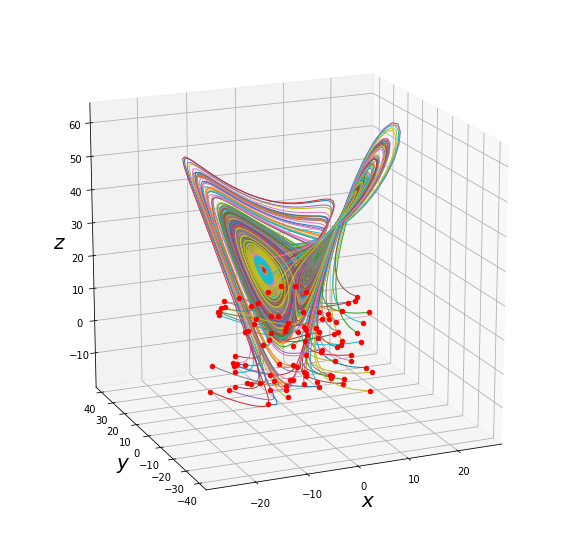

In [ ]:
# The subplot_kw parameter allows you to specify additional keyword arguments to be passed to the 
# subplot's constructor. In this case, the projection keyword argument is being used to specify that 
# the subplot should be 3D.
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
# fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})


# For each of the 100 trajectories
for j in range(100):
    # j=0--------0-----------800-----------------size:800-- each trajectory has len 801, 
    # and we always remove one observation to leave 800
    # j=1--------800---------1600----------------size:800--
    # j=2--------1600--------2600----------------size:800--
    # and so on ...
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    # without transposing is a list with 801 (801->rows are the 
    # ones that are always destructured, 3) values that we would 
    # have to store in 801 variables.
    # transposed is a list with 3 (3, 801) values


    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')
ax.set_xlabel('$x$', size = 20)  
ax.set_ylabel('$y$', size = 20)  
ax.set_zlabel('$z$', size = 20)  
ax.view_init(18, -113)
plt.show()

In [ ]:
j=1
print(x_t[j,:,:].shape)
print(x_t[j,:,:].T.shape)
print(nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:].shape)
print(x_t[j,:-1,:].shape)

(801, 3)
(3, 801)
(800, 3)
(800, 3)


In [ ]:
print(nn_input.shape)
print(x_t.shape)
print(x_t.size) #100 trajectories, 801 steps in each path, 3 state variables
100*801*3

(80000, 3)
(100, 801, 3)
240300


240300

In [ ]:
# Define model 
def model(input_dim, output_dim):

    deep_approx = keras.models.Sequential()

    deep_approx.add(layers.Dense(10, 
                                 input_dim=input_dim, 
                                 activation='sigmoid'))

    deep_approx.add(layers.Dense(10, 
                                 activation='relu'))

    deep_approx.add(layers.Dense(output_dim, 
                                 activation='linear'))

    return deep_approx

In [ ]:
deep_approx = model(3,3)

In [ ]:
# Compile model 
deep_approx.compile(loss='mse', optimizer='adam')

In [ ]:
# Fit model 
History = deep_approx.fit(nn_input, nn_output, epochs=100)

In [ ]:
# Predict three new trajectories 
num_traj = 3
nn_flow = np.zeros((num_traj, len(t), 3))

np.random.seed(139)
nn_flow[:, 0, :] = -15 + 30*np.random.random((num_traj, 3))
 
for jj, tval in enumerate(t[:-1]):
    nn_flow[:,jj+1, :] = deep_approx.predict(nn_flow[:, jj,:])

In [ ]:
# for each of the three initial conditions calculate a trajectory with 801 observations 
# and three state variables. This gives us (3, 801, 3)
x_t = np.array([integrate.odeint(lorenz_deriv, nn_flow[i, 0, :], t) for i in range(num_traj)])

In [ ]:
print(x_t.shape)

(3, 801, 3)


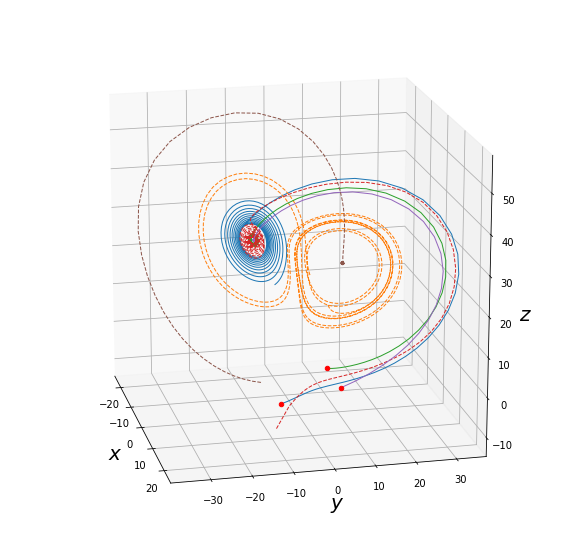

In [ ]:
fig = plt.figure(figsize=(10,10))
# fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
ax = fig.add_subplot(111, projection='3d')
for j in range(num_traj):
    
    x, y, z = x_t[j, :, :].T
    xd, yd, zd = nn_flow[j, :, :].T

    ax.plot(x, y, z, linewidth=1)
    ax.plot(xd, yd, zd, '--', lw=1)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.scatter(x[0], y[0], z[0], color='r')

ax.set_xlabel('$x$', size = 20)  
ax.set_ylabel('$y$', size = 20)  
ax.set_zlabel('$z$', size = 20) 
ax.view_init(18, -13)
plt.show()